# Khám phá Giá trị Quyền chọn và Lợi thế Giao dịch

**Mục tiêu:**
* Hiểu cách giá trị của một quyền chọn thay đổi khi đáo hạn dựa trên đường đi giá của tài sản cơ sở.
* Minh họa trực quan Lãi/Lỗ (P&L) của một vị thế mua quyền chọn.
* Khám phá ý tưởng về "lợi thế giao dịch" (trading edge) khi so sánh giá lý thuyết với giá thị trường.

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Đảm bảo các module trong thư mục cha có thể được import
if '..' not in sys.path:
    sys.path.append('..')

from core.black_scholes import european_call_price
from core.gbm_simulator import simulate_gbm_paths
from core.option_analyzer import analyze_trading_edge, calculate_option_pnl_at_expiry

sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6) # Kích thước mặc định cho các biểu đồ

## 2. Giá trị Đáo hạn của một Hợp đồng Quyền chọn

Mô phỏng một đường giá tài sản và xem xét Lãi/Lỗ (P&L) của một vị thế mua Quyền chọn Mua (Call Option) tại thời điểm đáo hạn.

**Các tham số cho kịch bản:**
* Giá tài sản ban đầu ($S_0$): 100
* Giá thực hiện ($K$): 100
* Độ biến động ($\sigma$): 30% (0.30)
* Lãi suất phi rủi ro ($r$): 5% (0.05)
* Thời gian đến đáo hạn ($T$): 1 năm

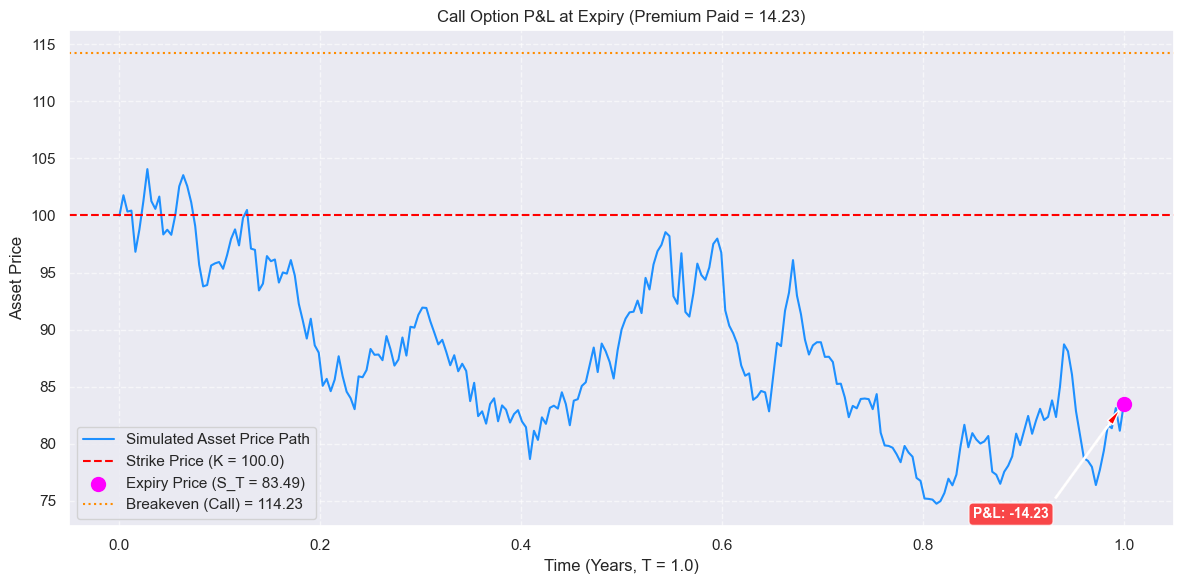

Initial Asset Price (S0): 100.0
Strike Price (K): 100.0
Volatility (σ): 30%
Risk-free rate (r): 5%
Time to Expiry (T): 1.0 year(s)
Calculated Premium Paid: 14.23
Simulated Asset Price at Expiry (S_T): 83.49
P&L for this specific path: $-14.23


In [22]:
# Tham số kịch bản
S0_pnl = 100.0
K_pnl = 100.0
T_pnl_years = 1.0
r_pnl_annual = 0.05
sigma_pnl_annual = 0.30

# Tính phí quyền chọn (premium) lý thuyết đã trả
premium_paid = european_call_price(S0_pnl, K_pnl, T_pnl_years, r_pnl_annual, sigma_pnl_annual)

# Mô phỏng một đường giá tài sản
num_steps_path = 252  # Số ngày giao dịch giả định trong một năm
dt_path = T_pnl_years / num_steps_path

# Chạy cell này nhiều lần sẽ tạo ra các đường giá ngẫu nhiên khác nhau
simulated_asset_path = simulate_gbm_paths(
    S0=S0_pnl,
    mu=r_pnl_annual,  # Giả sử drift bằng lãi suất phi rủi ro
    sigma=sigma_pnl_annual,
    T=T_pnl_years,
    dt=dt_path,
    num_paths=1,
    random_seed=None
)[0]

S_T_simulated = simulated_asset_path[-1] # Giá tài sản tại ngày đáo hạn

# Tính P&L cho kịch bản này
pnl_scenario = calculate_option_pnl_at_expiry(
    S_T=S_T_simulated,
    K=K_pnl,
    premium_transacted=premium_paid,
    option_type="call",
    position_type="long"
)

# --- Vẽ biểu đồ ---
plt.figure()
time_axis = np.linspace(0, T_pnl_years, num_steps_path + 1)

plt.plot(time_axis, simulated_asset_path, color='dodgerblue', linewidth=1.5, label="Simulated Asset Price Path")
plt.axhline(K_pnl, color='red', linestyle='--', linewidth=1.5, label=f"Strike Price (K = {K_pnl})")

# Đánh dấu giá đáo hạn và P&L
plt.scatter(time_axis[-1], S_T_simulated, color='magenta', s=100, zorder=5, label=f"Expiry Price (S_T = {S_T_simulated:.2f})")
pnl_color = 'green' if pnl_scenario >= 0 else 'red'
plt.annotate(f"P&L: {pnl_scenario:.2f}",
             xy=(time_axis[-1], S_T_simulated),
             xytext=(time_axis[-1] * 0.85, S_T_simulated + (5 if pnl_scenario >=0 else -10) ), # Điều chỉnh vị trí text
             arrowprops=dict(facecolor=pnl_color, shrink=0.05, width=1, headwidth=5),
             bbox=dict(boxstyle="round,pad=0.3", fc=pnl_color, alpha=0.7),
             fontsize=10, color='white', fontweight='bold'
            )


# Điểm hòa vốn
breakeven_call = K_pnl + premium_paid
plt.axhline(breakeven_call, color='darkorange', linestyle=':', linewidth=1.5, label=f"Breakeven (Call) = {breakeven_call:.2f}")

plt.title(f"Call Option P&L at Expiry (Premium Paid = {premium_paid:.2f})")
plt.xlabel(f"Time (Years, T = {T_pnl_years})")
plt.ylabel("Asset Price")
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Initial Asset Price (S0): {S0_pnl}")
print(f"Strike Price (K): {K_pnl}")
print(f"Volatility (σ): {sigma_pnl_annual*100:.0f}%")
print(f"Risk-free rate (r): {r_pnl_annual*100:.0f}%")
print(f"Time to Expiry (T): {T_pnl_years} year(s)")
print(f"Calculated Premium Paid: {premium_paid:.2f}")
print(f"Simulated Asset Price at Expiry (S_T): {S_T_simulated:.2f}")
print(f"P&L for this specific path: ${pnl_scenario:.2f}")

## 3. Lợi thế Giao dịch (Trading Edge)

Khái niệm "trading edge" dựa trên việc tìm kiếm sự chênh lệch giữa giá trị lý thuyết của quyền chọn (tính theo mô hình như Black-Scholes) và giá được giao dịch trên thị trường.

**Ý tưởng:**
*   Nếu Giá Lý Thuyết ($P_{BS}$) > Giá Thị Trường ($P_{Market}$) để mua $\implies$ Mua quyền chọn (vì nó có thể đang được định giá thấp).
*   Nếu $P_{BS}$ < Giá Thị Trường ($P_{Market}$) để bán $\implies$ Bán quyền chọn (vì nó có thể đang được định giá cao).

Giao dịch lặp đi lặp lại dựa trên "edge" này, với giả định mô hình là hợp lý, có thể mang lại P&L kỳ vọng dương theo thời gian.

**Thiết lập Kịch bản Edge:**
*   Các tham số cơ sở: $S=100, K=100, \sigma=0.30, r=0.05, T=1$ năm.
*   Giá Call Black-Scholes lý thuyết ($P_{BS}$) với các tham số này sẽ được tính.
*   Giả sử giá mua Call trên thị trường (Market Ask Price) là $13.50.
*   Lợi thế giao dịch (Edge) = $P_{BS}$ - Market Ask Price.

--- Trading Edge Analysis ---
Theoretical BS Call Price (σ=30%): $14.2313
Market Ask Price (Price Paid): $13.9813
Identified Edge per Share: $0.2500

Results from 50000 simulated trades:
Average Simulated P&L per Trade: $0.8021
Std. Dev. of Simulated P&L: $23.5276
Simulated Probability of Profit: 33.45%


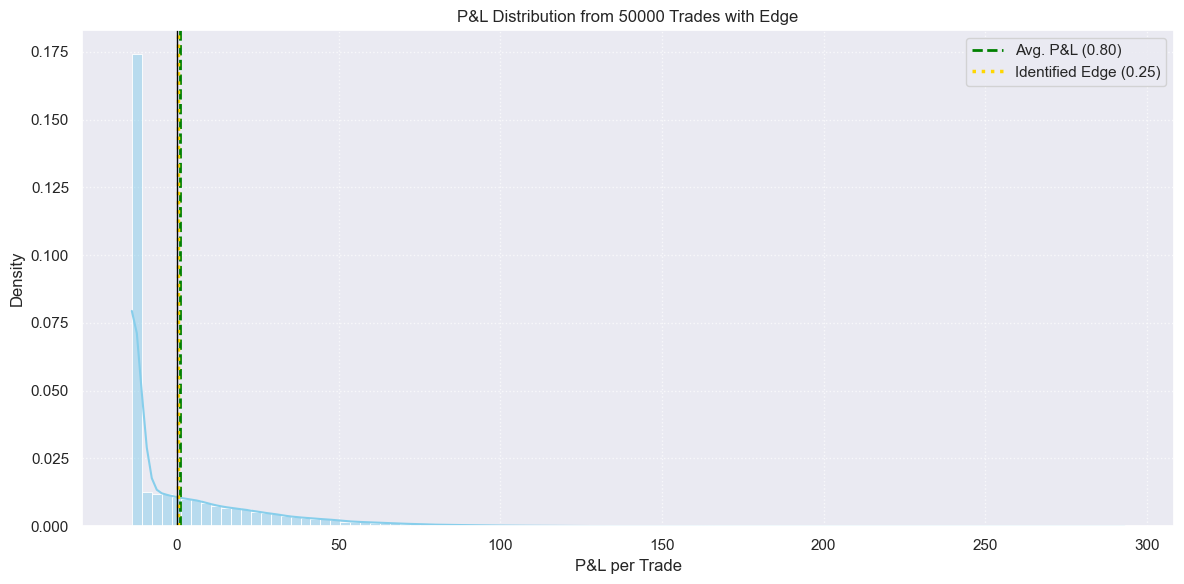

In [15]:
# Tham số cho phân tích trading edge
S0_edge = 100.0
K_edge = 100.0
T_edge_years = 1.0
r_edge_annual = 0.05
sigma_model_for_bs = 0.30  # Sigma mà mô hình BS sử dụng để xác định giá trị lý thuyết

# Tính giá Call lý thuyết dựa trên sigma của mô hình
theoretical_call_price = european_call_price(S0_edge, K_edge, T_edge_years, r_edge_annual, sigma_model_for_bs)

# Giả định giá mua trên thị trường thấp hơn giá lý thuyết một chút
market_ask_price = theoretical_call_price - 0.25  # Giả sử edge là $0.25

# Số lượng mô phỏng giao dịch
num_simulations_edge = 50000

# Phân tích trading edge
# Giả định rằng thị trường thực tế (GBM simulation) cũng biến động theo sigma_model_for_bs
# Trong thực tế, sigma_gbm_simulation có thể khác, tạo ra kịch bản phức tạp hơn.
edge_analysis = analyze_trading_edge(
    S_initial=S0_edge,
    K=K_edge,
    T=T_edge_years,
    r=r_edge_annual,
    sigma_model_theoretical=sigma_model_for_bs, # Dùng để tính theoretical_bs_price bên trong hàm
    market_price_transacted=market_ask_price,
    option_type="call",
    trade_action="buy", # Chúng ta mua vì market_ask_price < theoretical_call_price
    mu_gbm_simulation=r_edge_annual,
    sigma_gbm_simulation=sigma_model_for_bs, # GBM khớp với mô hình
    num_sim_paths=num_simulations_edge,
    random_seed=42 # Để có kết quả lặp lại cho phân tích này
)

print("--- Trading Edge Analysis ---")
print(f"Theoretical BS Call Price (σ={sigma_model_for_bs*100:.0f}%): ${edge_analysis['theoretical_bs_price']:.4f}")
print(f"Market Ask Price (Price Paid): ${edge_analysis['market_transaction_price']:.4f}")
print(f"Identified Edge per Share: ${edge_analysis['identified_edge_per_share']:.4f}")
print(f"\nResults from {num_simulations_edge} simulated trades:")
print(f"Average Simulated P&L per Trade: ${edge_analysis['simulated_average_pnl']:.4f}")
print(f"Std. Dev. of Simulated P&L: ${edge_analysis['simulated_std_dev_pnl']:.4f}")
print(f"Simulated Probability of Profit: {edge_analysis['simulated_prob_of_profit']*100:.2f}%")

# Trực quan hóa phân phối P&L
plt.figure()
sns.histplot(edge_analysis["pnl_distribution_simulated_array"], bins=100, kde=True, stat="density", color="skyblue")
plt.axvline(edge_analysis["simulated_average_pnl"], color='green', linestyle='dashed', linewidth=2, label=f"Avg. P&L ({edge_analysis['simulated_average_pnl']:.2f})")
plt.axvline(edge_analysis["identified_edge_per_share"], color='gold', linestyle='dotted', linewidth=2.5, label=f"Identified Edge ({edge_analysis['identified_edge_per_share']:.2f})")
plt.axvline(0, color='black', linestyle='solid', linewidth=1)

plt.title(f"P&L Distribution from {num_simulations_edge} Trades with Edge")
plt.xlabel("P&L per Trade")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Mô phỏng Đường cong Vốn (Equity Curve)

Minh họa cách vốn có thể tăng trưởng (hoặc giảm) theo thời gian khi thực hiện một chuỗi các giao dịch độc lập, mỗi giao dịch đều có một "trading edge" kỳ vọng dương.

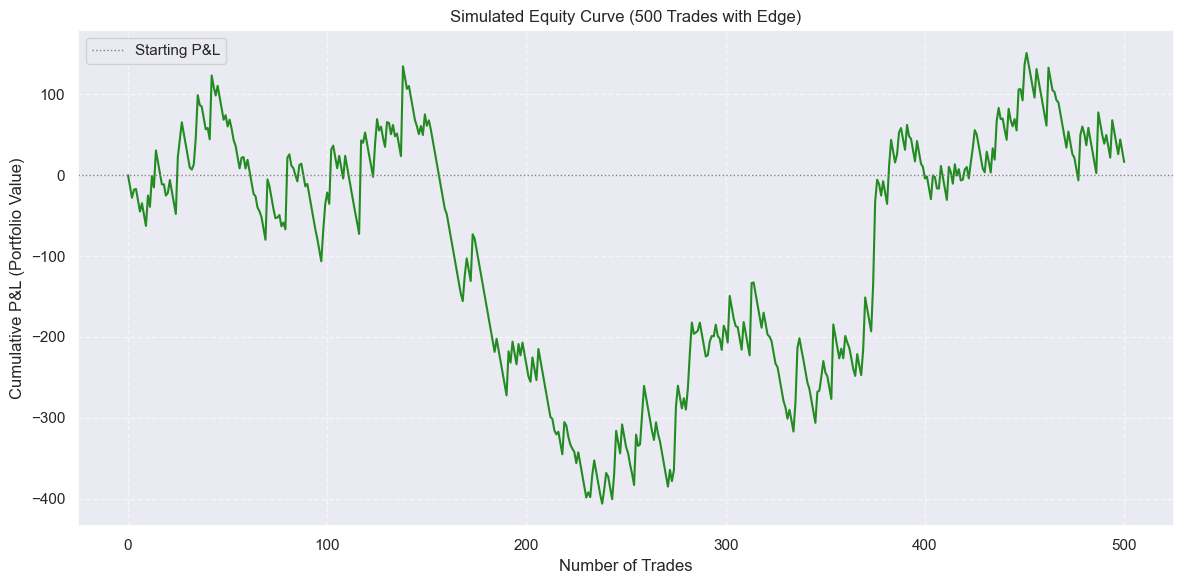

In [25]:
# Sử dụng mảng P&L từ phân tích trading edge trước đó
pnl_distribution = edge_analysis["pnl_distribution_simulated_array"]

# Chọn số lượng giao dịch để mô phỏng cho đường cong vốn
num_trades_equity_curve = 500

# Lấy ngẫu nhiên các P&L từ phân phối đã mô phỏng
# replace=True cho phép chúng ta mô phỏng nhiều hơn số P&L gốc nếu cần,
# hoặc đơn giản là chọn ngẫu nhiên từ tập P&L hiện có.
if len(pnl_distribution) < num_trades_equity_curve:
    simulated_trade_pnls = np.random.choice(pnl_distribution, size=num_trades_equity_curve, replace=True)
else:
    simulated_trade_pnls = np.random.choice(pnl_distribution, size=num_trades_equity_curve, replace=False)


initial_capital_equity = 0 # Bắt đầu với vốn P&L bằng 0
equity_curve = np.cumsum(np.insert(simulated_trade_pnls, 0, initial_capital_equity))

plt.figure()
plt.plot(np.arange(len(equity_curve)), equity_curve, color='forestgreen', linewidth=1.5)

plt.title(f"Simulated Equity Curve ({num_trades_equity_curve} Trades with Edge)")
plt.xlabel("Number of Trades")
plt.ylabel("Cumulative P&L (Portfolio Value)")
plt.axhline(initial_capital_equity, color='grey', linestyle=':', lw=1, label="Starting P&L")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()